In [1]:
from xgb_results import xgb_results_regression
from pprint import pprint
from utils import *
from get_data import get_uci_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from genetic import GeneticAlgorithmSampler
from fitness_funcs import *
from IPython.display import clear_output

In [2]:
x_train, x_test, y_train, y_test, description = get_uci_dataset(2) #Dataset 1 has 2 colums we need to predict...
pprint(description)

Number of features:  23
Number of training examples:  1711
Number of test examples:  428
{'categorical features': [],
 'dataset name': 'AIDS Clinical Trials Group Study 175',
 'number of features': 23,
 'number of samples': 2139,
 'variables information':        name     role        type         demographic  \
0    pidnum       ID     Integer                None   
1       cid   Target      Binary                None   
2      time  Feature     Integer                None   
3       trt  Feature     Integer                None   
4       age  Feature     Integer                 Age   
5      wtkg  Feature  Continuous                None   
6      hemo  Feature      Binary                None   
7      homo  Feature      Binary  Sexual Orientation   
8     drugs  Feature      Binary                None   
9    karnof  Feature     Integer                None   
10   oprior  Feature      Binary                None   
11      z30  Feature      Binary                None   
12   zprior  Fea

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1711, 23)
(1711,)
(428, 23)
(428,)


In [4]:
all_data_results = xgb_results_regression(x_train, x_test, y_train, y_test)
pprint(all_data_results)

{'Testing Metrics': {'MSE': 0.09032473560251866,
                     'Pearson': 0.7116221023900426,
                     'R^2 Score': 0.49901455274133955,
                     'Spearman': 0.607362871658546},
 'Training Metrics': {'MSE': 0.0004781508511815307,
                      'Pearson': 0.9988596827205314,
                      'R^2 Score': 0.9974183972225262,
                      'Spearman': 0.7454155672704781}}


In [5]:
guesses = get_baseline_guesses(np.concatenate((y_train, y_test)))
baseline_results = get_baseline_results(y_test, guesses)
pprint(baseline_results)

{'mean': {'MSE': 0.18035174548510868, 'R^2': -0.00031956111497111195},
 'median': {'MSE': 0.23598130841121495, 'R^2': -0.308868501529052}}


In [6]:
# sample rates are from 10 to 1000 in increments of 10
COMPARE = True
REDUNDANCY = 5 # TODO: was 10
sample_sizes = [10, 50, 100, 150]

mse_dict, mse_dict_improved = {}, {}


for index, sample_size in enumerate(sample_sizes):
    clear_output()
    print('Sample Size:', sample_size)
    
    mse_list, mse_improved_list = [], []
    
    for i in range(REDUNDANCY):
        np.random.seed(i)
        
        x_train_sample, y_train_sample = sample_data(x_train, y_train, sample_size)
        
        Sampler = GeneticAlgorithmSampler(
            fitness_function=fitness_wasserstein_distance,
            sample_size=sample_size,
            x_train=x_train,
            y_train=y_train,
            population_size=10,
            max_generations=5,
            mutation_rate=0.5,
            mutation_cap=2,
            elite_size=2,
            verbose=False
        )
        
        x_train_new_sample, y_train_new_sample, history = Sampler.sample()
        
        results = xgb_results_regression(x_train_sample, x_test, y_train_sample, y_test)
        results_improved = xgb_results_regression(x_train_new_sample, x_test, y_train_new_sample, y_test)
        
        test_results, test_results_improved = results['Testing Metrics'], results_improved['Testing Metrics']
        
        if COMPARE:
            print('Original:', test_results['MSE'])
            print('Improved:', test_results_improved['MSE'])
            
        mse_list.append(test_results['MSE'])
        mse_improved_list.append(test_results_improved['MSE'])

    mse_dict[sample_size] = np.mean(mse_list)
    mse_dict_improved[sample_size] = np.mean(mse_improved_list)


Sample Size: 10
---	Generation 1	---
Best fitness:  2.7072748466594865
---	Generation 2	---
---	Generation 3	---
---	Generation 4	---


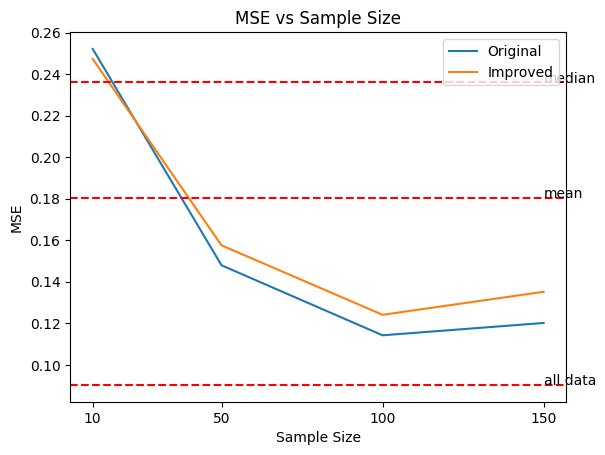

In [ ]:
# graph mse results
plt.plot(list(mse_dict.keys()), list(mse_dict.values()))
plt.plot(list(mse_dict_improved.keys()), list(mse_dict_improved.values()))
plt.xlabel('Sample Size')
plt.ylabel('MSE')
plt.legend(['Original', 'Improved'])
# Draw a line for each baseline
for baseline, value in baseline_results.items():
    plt.axhline(value["MSE"], color='r', linestyle='--')
    plt.text(sample_sizes[-1], value["MSE"], baseline)

# Draw a line for best result
all_data_mse = all_data_results['Testing Metrics']['MSE']
plt.axhline(all_data_mse, color='r', linestyle='--')
plt.text(sample_sizes[-1], all_data_mse, 'all data')
    
plt.xticks(sample_sizes) #TODO: change this if needed
plt.title('MSE vs Sample Size')
plt.show()